### Initialization of code

In [1]:
#Initialize and validate GPU on torch

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.current_device())
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))

device

0
1
NVIDIA GeForce GTX 1650 Ti


device(type='cuda', index=0)

In [2]:
#Import necessary libraries

import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import logging

from anomalib.data import MVTec
from anomalib.models import Patchcore, EfficientAd
from anomalib.engine import Engine
from anomalib.data.utils import read_image
from lightning.pytorch.callbacks import EarlyStopping

from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams, PointStruct

/workspaces/eng-ai-agents/.venv/lib/python3.11/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


Setup Logging

In [3]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

### Initialize data structures and variables

In [4]:
#Based on the assignment requirements, only include flat surface categories
categories = ['tile', 'leather', 'grid']

#Store model results to vizualize later
results = {}

#Initialize quadrant DB and store feature extractors for the similarity calculation later
qdrant_client = QdrantClient(":memory:")
feature_extractors = {}

### Initialize datamodule

A datamodule is an instance of a dataset that would allow us to use it for a particular model with a certain set of parameters such as image size, and batch size.  
Further, we would need many instances of this datasets for various kinds of models. Hence I am creating a function to return a new instance below.

MVTec is an anomaly detection dataset for various objects. We will be using this dataset as an example to see anomaly detection using anomalib package.  
As an example, we will be considering only 3 subdataset categories - tile, leather, and carpet

In [5]:
def setup_datamodule(category, batch_size) -> MVTec:
    datamodule = MVTec(
        category=category,
        image_size=(256, 256),
        train_batch_size=batch_size,
        eval_batch_size=batch_size
    )

    return datamodule

MVTec Dataset Visualization  

Below are a few sample images from the dataset:

Comparison of normal and anomolous images from the dataset
----------------------------------------------------------------------------------------------------


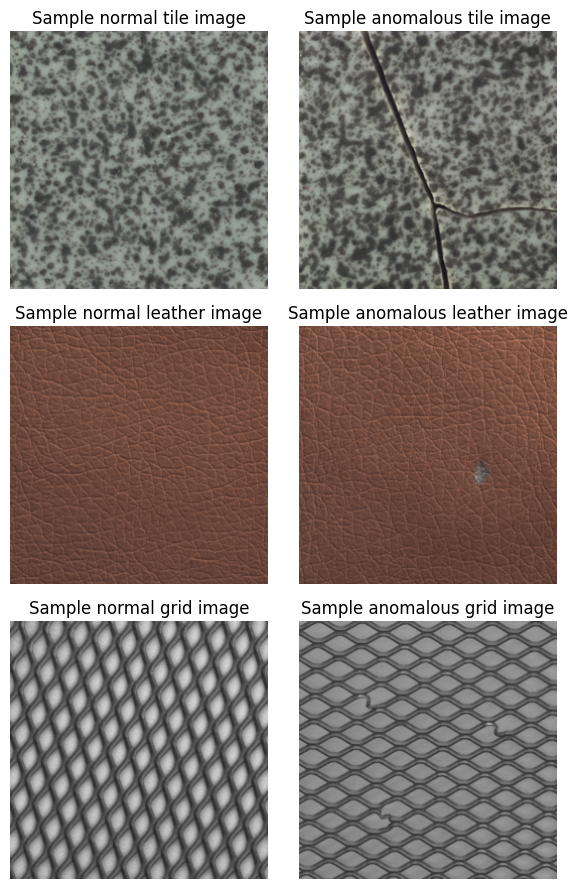

In [43]:
print("Comparison of normal and anomolous images from the dataset")
print("--"*50)
plt.figure(figsize=(6, len(categories) * 3))
for idx, category in enumerate(categories):
    datamodule = setup_datamodule(category, 100)
    datamodule.setup()

    i, data = next(enumerate(datamodule.test_dataloader()))
    normal_image = data["image"][data['label'] == 0][0].permute(1, 2, 0).numpy()
    anomalous_image = data["image"][data['label'] == 1][0].permute(1, 2, 0).numpy()

    plt.subplot(len(categories), 2, idx * 2 + 1)
    plt.imshow(normal_image)
    plt.title(f"Sample normal {category} image")
    plt.axis('off')  # Hide the axis

    plt.subplot(len(categories), 2, idx * 2 + 2)
    plt.imshow(anomalous_image)
    plt.title(f"Sample anomalous {category} image")
    plt.axis('off')  # Hide the axis

plt.tight_layout()
plt.show()

### PatchCore Model

As a first example, we will be training the patchcore model to perform anomaly detection.  
Patchcore is an unsupervised learning method to detect anomalies especially for industrial objects.  

Methodology:  

1. Feature Extraction  
a. Using a pretrained model, Patchcore uses the encoder of a pretrained model such as resnet (used in the below example) to extract features.  
b. PatchCore focuses on extracting intermediate feature maps from CNN layers, which retain more local, spatially consistent information compared to fully connected layers. These maps are then divided into "patches" to capture localized patterns across the image.  
c. Each patch is represented as a feature vector, encoding the local appearance within that patch.  

2. Coreset Sampling  
a. Patchcore model first constructs a memory bank callet as core-set to select a subset of important representative features from step 1 to make it computationally less expensive.  
b. This sampling inspired from kmeans or greedy helps reduce redundancy and stores only the most essential and diverse features in memory  
c. This reduced memory bank represents the "normal" distribution of patch features, against which future patches can be compared.  

3. Nearest Neighbour Search  
a. When a new image (possibly containing anomalies) is tested, patchcore model first extracts patch-level features in the same way as step 1.  
b. For each patch feature in the test image, the model computes the distance to the nearest neighbors in the core-set memory bank. If a patch in the test image is significantly different from the normal patches in the memory bank, it’s considered anomalous.  
c. The distance metric is commonly either cosine similarity or euclidean

4. Anomaly score calculation  
a. The anomaly score for an entire image is calculated based on the highest or average distances of its patches from their closest matches in the core-set.  
b. PatchCore also generates an anomaly heatmap (shown later during visualization), which highlights areas in the image that are most likely anomalous.  

Evaluation Metrics  

1. AUROC: Area under receiver operating curve.  
The ROC is computed by plotting the true positive rate against the false positive rate at various threshold settings. The area under this curve quantifies the model’s discriminative ability; a value of 1.0 indicates perfect discrimination, while a value of 0.5 indicates no discrimination.  
i. Pixel level AUROC: For each pixel in an image, the model outputs an anomaly score, which indicates the likelihood of that pixel being anomalous.  
ii. Image level AUROC: This is an aggregation of Pixel AUROC for the entire image.  

2. F1 score:  
This score is computed using the formula: $2 \times \frac{(\text{Precision} \times \text{Recall})}{(\text{Precision} + \text{Recall})}$  
where Precision = TP / (TP + FP) and Recall = TP / (TP + FN)  
i. Pixel level F1 score: This is the f1 score computed using the precision and recall of each pixel.  
ii. Image level F1 score: This is the aggregation of th pixel F1 scores over the entire image.  


In the below code cell, we are going to be defining a function to return an instance of the patchcore model. For this model, we are going to use the following arguments:  
i. `backbone="wide_resnet50_2"` - This means that we will be using resnet50 for feature extraction  
ii. `coreset_sampling_ratio=0.1` - This means that we will be using only 10% of all the patches generated to create the core-set

In [6]:
def get_patchcore_model():
    model = Patchcore(
        backbone="wide_resnet50_2",
        coreset_sampling_ratio=0.1
    )

    return model

### EfficientAd Model

EfficientAd is an anomaly detection model that utilizes both supervised and unsupervised learning methodologies to get results.  
EfficientAD employs a teacher-student approach, where a teacher model is trained first to understand the distribution of normal data, and then a student model learns from the teacher’s knowledge.  

Methodology:  

1. Feature Extraction:  
a. EfficientAD leverages a pretrained CNN backbone, such as EfficientNet. This model is fine-tuned for anomaly detection by adapting its layers to focus on relevant features.  
b. The CNN extracts multi-scale feature maps that capture various levels of detail, from fine textures to high-level semantic information.  
c. The model divides input images into smaller patches, allowing for localized analysis of the content. For each patch, feature vectors are extracted and then aggregated to create a comprehensive representation of the entire image.  

2. Normal Data Training:  
a. The model is trained on non anomalous data and learns to identify the patterns and distributions inherent in the normal samples (without any defects).  
b. The teacher model establishes a statistical representation of normal patches.  

3. Anomaly Detection:  
a. The student model uses the knowledge acquired from the teacher to estimate the likelihood of new patches belonging to the learned normal distribution. Anomalies are identified based on the likelihood score of these patches.  
b. Each patch receives an anomaly score computed via a gaussian density function, where lower scores indicate a higher probability of being anomalous. The model can then classify patches as normal or anomalous based on predefined thresholds.  

Evaluation Metrics:  
These metrics are similar to the ones used in patchcore, namely AUROC and F1 scores.  

In the below code cell, we are going to be defining a function to return an instance of the efficientad model.

In [7]:
def get_efficientad_model():
    model = EfficientAd()

    return model

### Model Training

In the below code cell, we are going to use the 2 model instances defined above to train for anomaly detection on the MVTec dataset we had initialized before.  

The process for training is as follows:  
1. Define a callback function `es_callback` that will ensure that the model will stop training once the image AUROC score starts decreasing after 1 epoch.
2. For patchcore model, we will train the dataset with a batch size of 16 on each category seperately with a maximum of 1 epoch per model.
3. For efficientad model, we will train the dataset using a batch size of 1 on each category seperately with a maximum of 5 epochs per model.
4. Now we define an anomalib `engine` instance that will allow us to train the model.
5. Training begins using `model.fit`
6. Once it is completed, we will store the test performance results in our previously defined dictionary `results`.

In [8]:
def train_and_evaluate_model(model_type="patchcore"):
    for category in categories:
        logger.info(f"Training {model_type} on {category}")

        es_callback = EarlyStopping(
            monitor="image_AUROC",
            mode="max",
            patience=1,
        )

        # Initialize a new model and dataset
        if model_type == "patchcore":
            model = get_patchcore_model()
            datamodule = setup_datamodule(category, 16)
            callbacks = []
            max_epochs = 1

        else:
            model = get_efficientad_model()
            datamodule = setup_datamodule(category, 1)
            callbacks = [es_callback]
            max_epochs = 5

        # Initialize training engine
        engine = Engine(callbacks=callbacks, max_epochs=max_epochs)

        # Train and evaluate
        engine.fit(model=model, datamodule=datamodule)
        evaluation = engine.test(model=model, datamodule=datamodule)

        results[f"{model_type}_{category}"] = evaluation

Begin training for Patchcore model

In [10]:
train_and_evaluate_model(model_type="patchcore")

INFO:__main__:Training patchcore on tile
INFO:anomalib.models.components.base.anomaly_module:Initializing Patchcore model.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/wide_resnet50_2.racm_in1k)
INFO:timm.models._hub:[timm/wide_resnet50_2.racm_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (fc.weight, fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
INFO:anomalib.data.image.mvtec:Found the dataset.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/workspaces/eng-ai-agents/.venv/lib/python3.11/site-packages/lightning/pytorch/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name                  | Type                  

Training: |          | 0/? [00:00<?, ?it/s]

/workspaces/eng-ai-agents/.venv/lib/python3.11/site-packages/lightning/pytorch/loops/optimization/automatic.py:132: `training_step` returned `None`. If this was on purpose, ignore this warning...


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:anomalib.models.image.patchcore.lightning_model:Aggregating the embedding extracted from the training set.
INFO:anomalib.models.image.patchcore.lightning_model:Applying core-set subsampling to get the embedding.

















































































































































































































































































































































































































































































































































































































































































































































































































Testing: |          | 0/? [00:00<?, ?it/s]

INFO:anomalib.callbacks.timer:Testing took 44.26743149757385 seconds
Throughput (batch_size=16) : 2.6430266234536868 FPS


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │     0.986652135848999     │
│       image_F1Score       │    0.9818181991577148     │
│        pixel_AUROC        │    0.9475240707397461     │
│       pixel_F1Score       │    0.6207191944122314     │
└───────────────────────────┴───────────────────────────┘

INFO:__main__:Training patchcore on leather
INFO:anomalib.models.components.base.anomaly_module:Initializing Patchcore model.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/wide_resnet50_2.racm_in1k)
INFO:timm.models._hub:[timm/wide_resnet50_2.racm_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (fc.weight, fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
INFO:anomalib.data.image.mvtec:Found the dataset.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/workspaces/eng-ai-agents/.venv/lib/python3.11/site-packages/lightning/pytorch/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name                  | Type               

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:anomalib.models.image.patchcore.lightning_model:Aggregating the embedding extracted from the training set.
INFO:anomalib.models.image.patchcore.lightning_model:Applying core-set subsampling to get the embedding.

















































































































































































































































































































































































































































































































































































































































































































































































































Testing: |          | 0/? [00:00<?, ?it/s]

INFO:anomalib.callbacks.timer:Testing took 43.70695209503174 seconds
Throughput (batch_size=16) : 2.8370772624544403 FPS


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │            1.0            │
│       image_F1Score       │     0.994535505771637     │
│        pixel_AUROC        │     0.989837110042572     │
│       pixel_F1Score       │    0.4401133358478546     │
└───────────────────────────┴───────────────────────────┘

INFO:__main__:Training patchcore on grid
INFO:anomalib.models.components.base.anomaly_module:Initializing Patchcore model.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/wide_resnet50_2.racm_in1k)
INFO:timm.models._hub:[timm/wide_resnet50_2.racm_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (fc.weight, fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
INFO:anomalib.data.image.mvtec:Found the dataset.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/workspaces/eng-ai-agents/.venv/lib/python3.11/site-packages/lightning/pytorch/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name                  | Type                  

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:anomalib.models.image.patchcore.lightning_model:Aggregating the embedding extracted from the training set.
INFO:anomalib.models.image.patchcore.lightning_model:Applying core-set subsampling to get the embedding.

















































































































































































































































































































































































































































































































































































































































































































































































































Testing: |          | 0/? [00:00<?, ?it/s]

INFO:anomalib.callbacks.timer:Testing took 29.6324245929718 seconds
Throughput (batch_size=16) : 2.6322516996634824 FPS


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9799498915672302     │
│       image_F1Score       │    0.9649122953414917     │
│        pixel_AUROC        │    0.9797407388687134     │
│       pixel_F1Score       │    0.3814127445220947     │
└───────────────────────────┴───────────────────────────┘

Begin Training for Efficientad model

In [12]:
train_and_evaluate_model(model_type="efficientad")

INFO:__main__:Training efficientad on tile
INFO:anomalib.models.components.base.anomaly_module:Initializing EfficientAd model.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
INFO:anomalib.data.image.mvtec:Found the dataset.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type                     | Params | Mode 
---------------------------------------------------------------------------
0 | model                 | EfficientAdModel         | 8.1 M  | train
1 | _transform            | Compose                  | 0      | train
2 | normalization_metrics | MetricCollection         | 0      | train
3 | image_threshold       | F1AdaptiveThreshold      | 0      | train
4 | pixel_threshold       | F1AdaptiveThreshold      | 0      | train
5 | image_metrics         | AnomalibMetricCollection | 0      | train
6 | pixel_metrics         | AnomalibMetricCollection | 0      | train
----------------------------

Training: |          | 0/? [00:00<?, ?it/s]

INFO:anomalib.models.image.efficient_ad.lightning_model:Load pretrained teacher model from pre_trained/efficientad_pretrained_weights/pretrained_teacher_small.pth
/workspaces/eng-ai-agents/.venv/lib/python3.11/site-packages/anomalib/models/image/efficient_ad/lightning_model.py:98: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case 

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:anomalib.models.image.efficient_ad.lightning_model:Calculate Validation Dataset Quantiles
Calculate Validation Dataset Quantiles: 100%|██████████| 117/117 [00:05<00:00, 22.53it/s]


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:anomalib.models.image.efficient_ad.lightning_model:Calculate Validation Dataset Quantiles
Calculate Validation Dataset Quantiles: 100%|██████████| 117/117 [00:03<00:00, 36.82it/s]


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:anomalib.models.image.efficient_ad.lightning_model:Calculate Validation Dataset Quantiles
Calculate Validation Dataset Quantiles: 100%|██████████| 117/117 [00:03<00:00, 37.90it/s]
INFO:anomalib.callbacks.timer:Training took 222.27 seconds
INFO:anomalib.data.image.mvtec:Found the dataset.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:anomalib.callbacks.timer:Testing took 43.22464966773987 seconds
Throughput (batch_size=1) : 2.7067888554183326 FPS


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9559884071350098     │
│       image_F1Score       │    0.9259259104728699     │
│        pixel_AUROC        │    0.7810075283050537     │
│       pixel_F1Score       │    0.5535957217216492     │
└───────────────────────────┴───────────────────────────┘

INFO:__main__:Training efficientad on leather
INFO:anomalib.models.components.base.anomaly_module:Initializing EfficientAd model.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
INFO:anomalib.data.image.mvtec:Found the dataset.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type                     | Params | Mode 
---------------------------------------------------------------------------
0 | model                 | EfficientAdModel         | 8.1 M  | train
1 | _transform            | Compose                  | 0      | train
2 | normalization_metrics | MetricCollection         | 0      | train
3 | image_threshold       | F1AdaptiveThreshold      | 0      | train
4 | pixel_threshold       | F1AdaptiveThreshold      | 0      | train
5 | image_metrics         | AnomalibMetricCollection | 0      | train
6 | pixel_metrics         | AnomalibMetricCollection | 0      | train
-------------------------

Training: |          | 0/? [00:00<?, ?it/s]

INFO:anomalib.models.image.efficient_ad.lightning_model:Load pretrained teacher model from pre_trained/efficientad_pretrained_weights/pretrained_teacher_small.pth
/workspaces/eng-ai-agents/.venv/lib/python3.11/site-packages/anomalib/models/image/efficient_ad/lightning_model.py:98: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case 

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:anomalib.models.image.efficient_ad.lightning_model:Calculate Validation Dataset Quantiles
Calculate Validation Dataset Quantiles: 100%|██████████| 124/124 [00:06<00:00, 20.21it/s]


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:anomalib.models.image.efficient_ad.lightning_model:Calculate Validation Dataset Quantiles
Calculate Validation Dataset Quantiles: 100%|██████████| 124/124 [00:06<00:00, 19.02it/s]
INFO:anomalib.callbacks.timer:Training took 158.24 seconds
INFO:anomalib.data.image.mvtec:Found the dataset.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:anomalib.callbacks.timer:Testing took 47.24724245071411 seconds
Throughput (batch_size=1) : 2.624491791861724 FPS


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │     0.962296187877655     │
│       image_F1Score       │    0.9354838728904724     │
│        pixel_AUROC        │    0.9448570013046265     │
│       pixel_F1Score       │    0.5136221051216125     │
└───────────────────────────┴───────────────────────────┘

INFO:__main__:Training efficientad on grid
INFO:anomalib.models.components.base.anomaly_module:Initializing EfficientAd model.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
INFO:anomalib.data.image.mvtec:Found the dataset.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type                     | Params | Mode 
---------------------------------------------------------------------------
0 | model                 | EfficientAdModel         | 8.1 M  | train
1 | _transform            | Compose                  | 0      | train
2 | normalization_metrics | MetricCollection         | 0      | train
3 | image_threshold       | F1AdaptiveThreshold      | 0      | train
4 | pixel_threshold       | F1AdaptiveThreshold      | 0      | train
5 | image_metrics         | AnomalibMetricCollection | 0      | train
6 | pixel_metrics         | AnomalibMetricCollection | 0      | train
----------------------------

Training: |          | 0/? [00:00<?, ?it/s]

INFO:anomalib.models.image.efficient_ad.lightning_model:Load pretrained teacher model from pre_trained/efficientad_pretrained_weights/pretrained_teacher_small.pth
/workspaces/eng-ai-agents/.venv/lib/python3.11/site-packages/anomalib/models/image/efficient_ad/lightning_model.py:98: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case 

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:anomalib.models.image.efficient_ad.lightning_model:Calculate Validation Dataset Quantiles
Calculate Validation Dataset Quantiles: 100%|██████████| 78/78 [00:03<00:00, 24.72it/s]


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:anomalib.models.image.efficient_ad.lightning_model:Calculate Validation Dataset Quantiles
Calculate Validation Dataset Quantiles: 100%|██████████| 78/78 [00:02<00:00, 30.18it/s]
INFO:anomalib.callbacks.timer:Training took 154.20 seconds
INFO:anomalib.data.image.mvtec:Found the dataset.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:anomalib.callbacks.timer:Testing took 28.706886768341064 seconds
Throughput (batch_size=1) : 2.71711804311783 FPS


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9674186110496521     │
│       image_F1Score       │    0.9380530714988708     │
│        pixel_AUROC        │    0.8553367853164673     │
│       pixel_F1Score       │    0.36969953775405884    │
└───────────────────────────┴───────────────────────────┘

### Visualizing model performance

From the above training sessions, we have collected the AUROC and F1 score metrics for both models in each of the 3 categories.  
The following code prints the result dictionary into a tabular format so that we can comare them in a better form. The average metrics for each model across all category is also shown at the bottom of the table.

In [10]:
from tabulate import tabulate

# Model Performance Summary
for model_type in ["patchcore", "efficientad"]:
    print("\n" + "#"*50)
    print(f"{model_type.title()} model performance summary:")
    print("#"*50 + "\n")
    summary = []
    image_auroc_scores = []
    pixel_auroc_scores = []
    for category in categories:
        auroc = results[f"{model_type}_{category}"][0]['image_AUROC']
        image_auroc_scores.append(results[f"{model_type}_{category}"][0]['image_AUROC'])
        pixel_auroc_scores.append(results[f"{model_type}_{category}"][0]['pixel_AUROC'])
        summary.append([category, f"{image_auroc_scores[-1]:.3f}", f"{pixel_auroc_scores[-1]:.3f}"])

    mean_image_auroc = np.mean(image_auroc_scores)
    mean_pixel_auroc = np.mean(pixel_auroc_scores)
    print(tabulate(summary, headers=["Category", "Image AUROC", "Pixel AUROC"], tablefmt="fancy_grid"))
    print("Average Image AUROC: ", f"{mean_image_auroc:.3f}")
    print("Average Pixel AUROC: ", f"{mean_pixel_auroc:.3f}")


##################################################
Patchcore model performance summary:
##################################################

╒════════════╤═══════════════╤═══════════════╕
│ Category   │   Image AUROC │   Pixel AUROC │
╞════════════╪═══════════════╪═══════════════╡
│ tile       │         0.987 │         0.948 │
├────────────┼───────────────┼───────────────┤
│ leather    │         1     │         0.99  │
├────────────┼───────────────┼───────────────┤
│ grid       │         0.98  │         0.98  │
╘════════════╧═══════════════╧═══════════════╛
Average Image AUROC:  0.989
Average Pixel AUROC:  0.972

##################################################
Efficientad model performance summary:
##################################################

╒════════════╤═══════════════╤═══════════════╕
│ Category   │   Image AUROC │   Pixel AUROC │
╞════════════╪═══════════════╪═══════════════╡
│ tile       │         0.956 │         0.781 │
├────────────┼───────────────┼───────────────┤
│ 

Metrics comparison via heatmaps:

The heatmaps below allow us to visually compare all the metrics efficiently across the models:

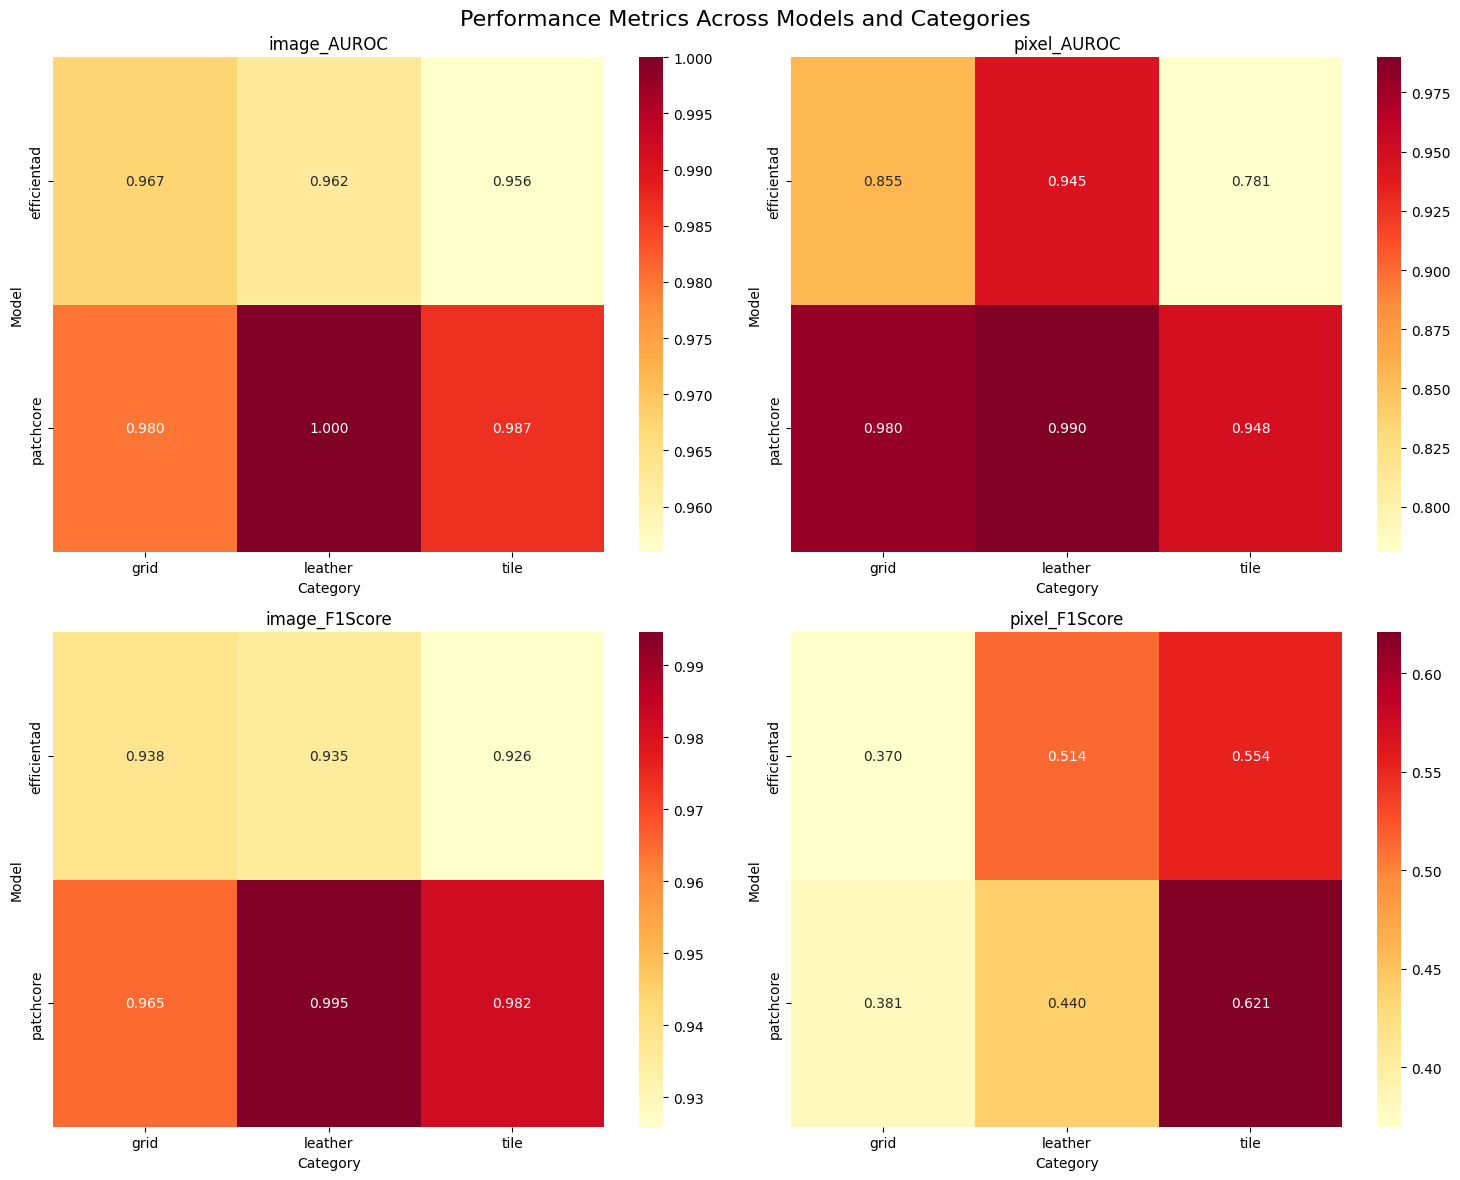

In [38]:
import pandas as pd
import seaborn as sns

"""Plot heatmap of performance metrics across models and categories."""
# Prepare data for heatmap
metrics = ['image_AUROC', 'pixel_AUROC', 'image_F1Score', 'pixel_F1Score']
data = []

for model in ["patchcore", "efficientad"]:
    for category in categories:
        key = f"{model}_{category}"
        metrics_dict = results[key][0]
        data.append([
            category,
            model,
            metrics_dict['image_AUROC'],
            metrics_dict['pixel_AUROC'],
            metrics_dict['image_F1Score'],
            metrics_dict['pixel_F1Score']
        ])

# Create DataFrame
df = pd.DataFrame(data, columns=['Category', 'Model'] + metrics)

# Create subplots for each metric
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Performance Metrics Across Models and Categories', fontsize=16)

for idx, metric in enumerate(metrics):
    ax = axes[idx//2, idx%2]
    pivot_data = df.pivot(index='Model', columns='Category', values=metric)
    sns.heatmap(pivot_data, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax)
    ax.set_title(f'{metric}')

plt.tight_layout()
plt.show()

Results Interpretation:  
From the table and heatmaps, we can make the following observations:  

1. Across image level AUROC metrics, the PatchCore model consistently outperforms the EfficientAD model. The average image AUROC for PatchCore is significantly higher (0.989) compared to EfficientAD (0.962), indicating better overall detection capability.  
2. The average pixel AUROC for PatchCore (0.972) is also superior to that of EfficientAD (0.860), suggesting that PatchCore is more effective at accurately identifying and localizing anomalies at the pixel level.
3. From the heatmaps, the leather category has better F1 and AUROC scores compared to other two categories. This suggests that the models are able to identify the differences between the normal vs anomalous patches easily for leather type surfaces.
4. The tile category has the lowest F1 scores for both models compared to the other categories. This indicates that even though anomaly localization may be good for tiles, the precision and recall may be low. This means that the anomaly detection for tile surfaces has difficulties.

In summary, the PatchCore model demonstrates superior performance across both image and pixel-level AUROC metrics when compared to EfficientAD in the MVTec dataset. This suggests that PatchCore is more effective for both detecting anomalies and localizing them accurately. While EfficientAD performs reasonably well, particularly in the leather category, it shows room for improvement in its pixel-level detection capabilities, especially for complex patterns like those found in tiles.

### Anomaly detection predictions on test data

Apart from numerical results, we can see how they translate to actually detecting and segmenting anomalies by plotting the mask and segmentation map for test images.  
The below code cell is plotting the results for anomaly detection across all three categories for patchcore and efficientab.

######################################################################
Anomaly detection results for Patchcore model on 2 sample categories:
######################################################################

Category: grid
--------------------------------------------------


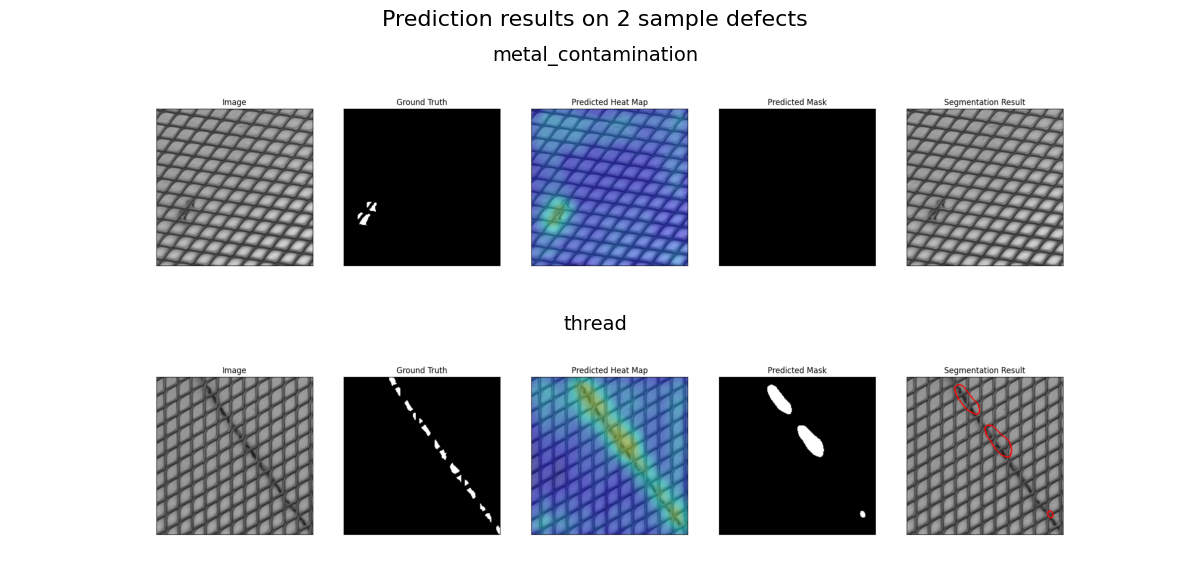


Category: leather
--------------------------------------------------


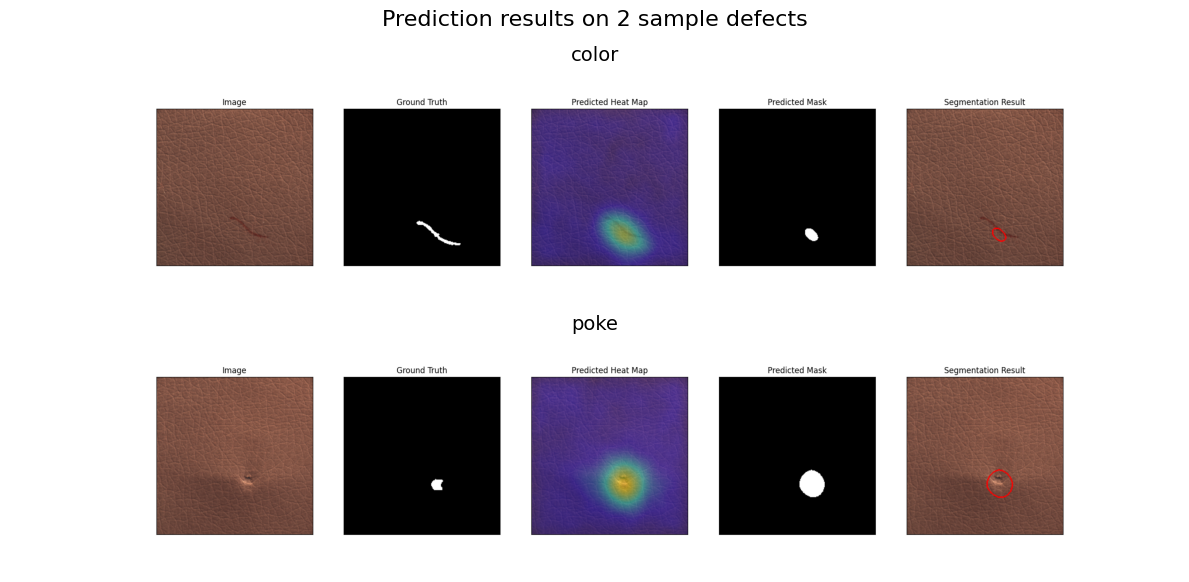

######################################################################
Anomaly detection results for EfficientAd model on 2 sample categories:
######################################################################

Category: tile
--------------------------------------------------


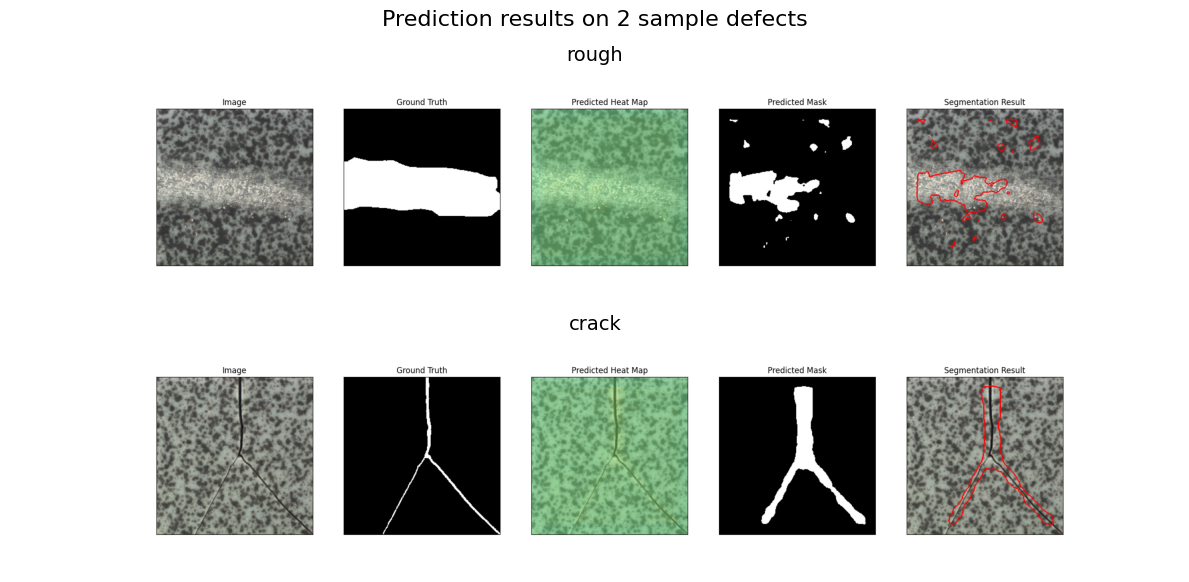


Category: leather
--------------------------------------------------


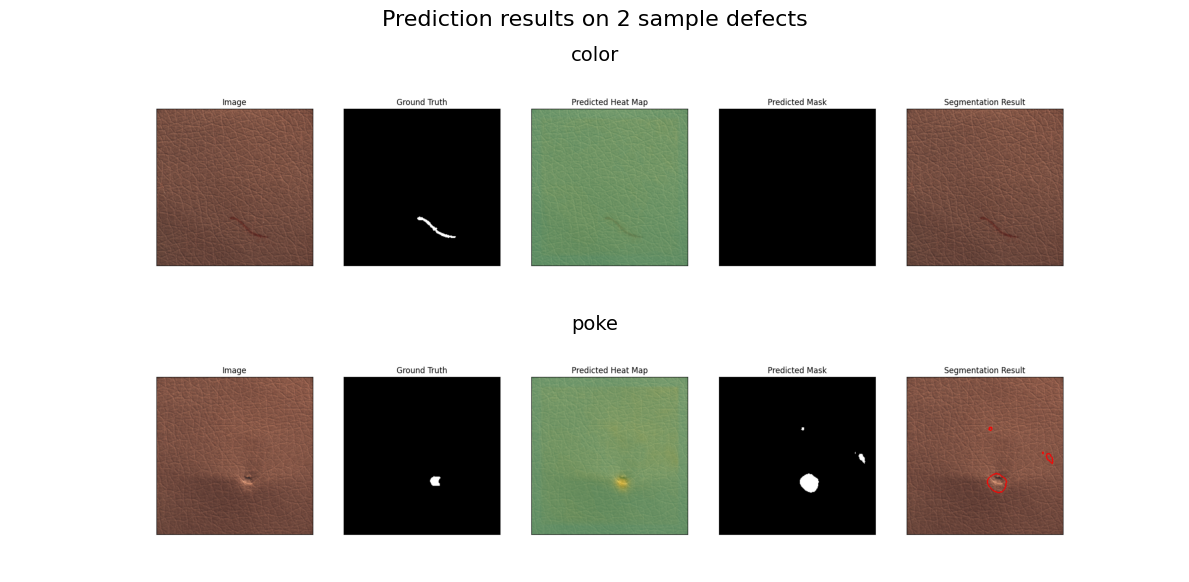

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

for model in ["Patchcore", "EfficientAd"]:
    print("#"*70)
    print(f"Anomaly detection results for {model} model on 2 sample categories:")
    print("#"*70)
    for category in np.array(categories)[np.random.choice(len(categories), 2, replace=False)]:
        print(f"\nCategory: {category}")
        print("-"*50)
        base_dir = rf"results/{model}/MVTec/{category}/latest/images"

        # Set up a dictionary to store sample images from each defect type
        defect_samples = {}

        # Gather a few images from each defect type
        for defect in os.listdir(base_dir)[:2]:
            defect_path = os.path.join(base_dir, defect)
            if os.path.isdir(defect_path):
                # List images within each defect type directory
                images = [os.path.join(defect_path, img) for img in os.listdir(defect_path)]
                defect_samples[defect] = images[0]

        # Plot the images
        fig, axs = plt.subplots(len(defect_samples), 1, figsize=(12, len(defect_samples)*3))
        fig.suptitle("Prediction results on 2 sample defects", fontsize=16)

        for row, (defect, image) in enumerate(defect_samples.items()):
            img = Image.open(image)
            ax = axs[row]
            ax.imshow(img)
            ax.axis("off")
            ax.set_title(defect, loc='center', fontsize=14)

        plt.tight_layout()
        plt.show()

From the above results, we can see that both models perform reasonable well to identify anomalies across a diverse set of defects. Even though Efficientab performed weaker based on metrics, its performance is very close to patchcore when visualized with real data.

### Image search using feature database

Now that we have seen that both model perform relatively well in extracting features, and detecting anomalies, we can construct a pipeline to store these features so that once presented with any image, we should be able to get the nearest 5 images. This will demonstrate the power of feature representation.  

The below code instantiates a vector database using qdrant for each model (so 2 collections).  
The feature size for patchcore is 512x512x32  
The feature size for efficientab is 384.

The above database will store all the features so that we can later use it to test out search functionality.

In [19]:
for model_type in ["patchcore", "efficientad"]:
    collection_name = f"{model_type}"
    vec_size = 512*32*32 if model_type == "patchcore" else 384
    qdrant_client.recreate_collection(
        collection_name=collection_name,
        vectors_config=VectorParams(size=vec_size, distance=Distance.COSINE)
    )

/tmp/ipykernel_18335/2294833633.py:4: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  qdrant_client.recreate_collection(


Load the models from the training checkpoints.

The below code will load the model weights into their respective model objects. This will allow us to use these trained models to perform inference and predictions.

In [ ]:
model_paths = {
    "Patchcore": "/workspaces/eng-ai-agents/assignments/assignment-4/results/Patchcore/MVTec/grid/latest/weights/lightning/model.ckpt",
    "EfficientAd": "/workspaces/eng-ai-agents/assignments/assignment-4/results/EfficientAd/MVTec/grid/latest/weights/lightning/model.ckpt"
}

pc_model = Patchcore.load_from_checkpoint(model_paths["Patchcore"]).to(device)
ea_model = EfficientAd.load_from_checkpoint(model_paths["EfficientAd"]).to(device)

INFO:anomalib.models.components.base.anomaly_module:Initializing Patchcore model.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/wide_resnet50_2.racm_in1k)
INFO:timm.models._hub:[timm/wide_resnet50_2.racm_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (fc.weight, fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.
INFO:anomalib.models.components.base.anomaly_module:Initializing EfficientAd model.


Insert Good and Defective images into their respective collections

For each image in the datamodule for a particular category, we will perform the following steps:  
1. Obtain the feature extractor for each model using the above model instances.
2. Extract the features - from both patchcore and efficientab models. The patchcore models uses features from layer 2 and layer 3, but we will only be storing layer 2 features.
3. Generate a Point Structure for the vector database that will contain the image id (index in the dataloader), the flattenned vector array, and metadata which includes the category, anomaly/normal label and the image path.
4. Once we have all points across the batch features, we will insert them into their respective model collections in the qdrant database.

In [21]:
img_idx = 0

for category in categories:
    datamodule = setup_datamodule(category, 8)
    datamodule.setup()

    for i, data in enumerate(datamodule.test_dataloader()):
        with torch.no_grad():
            img_idx += 1
            pc_feature_extractor = pc_model.model.feature_extractor #Main feature extractor for patchcore
            pc_features = pc_feature_extractor(data["image"].to(device))["layer2"]
            ea_feature_extractor = ea_model.model.teacher #Teacher model feature extractor for efficientad
            ea_features = ea_feature_extractor(data["image"].to(device))
            ea_features = nn.functional.adaptive_avg_pool2d(ea_features, (1, 1))

            # Prepare points for Qdrant for PatchCore
            pc_points = []
            for batch_index in range(data["image"].size(0)):
                pc_points.append(
                    PointStruct(
                        id = img_idx + batch_index,  # Unique ID for each point
                        vector=pc_features[batch_index].cpu().numpy().flatten().tolist(),
                        payload={
                            "label": data["label"][batch_index].cpu().numpy().tolist(),
                            "image_path": data["image_path"][batch_index]
                        }
                    )
                )

            # Upsert all points to Qdrant for PatchCore
            collection_name = "patchcore"
            qdrant_client.upsert(
                collection_name=collection_name,
                points=pc_points
            )

            # Prepare points for Qdrant for EfficientAD
            ea_points = []
            for batch_index in range(data["image"].size(0)):  # Loop through batch size
                ea_points.append(
                    PointStruct(
                        id = img_idx + batch_index,  # Unique ID for each point
                        vector=ea_features[batch_index].cpu().numpy().flatten().tolist(),
                        payload={
                            "label": data["label"][batch_index].cpu().numpy().tolist(),
                            "image_path": data["image_path"][batch_index]
                        }
                    )
                )

            # Upsert all points to Qdrant for EfficientAD
            collection_name = "efficientad"
            qdrant_client.upsert(
                collection_name=collection_name,
                points=ea_points
            )

            img_idx += 8

For example, the collection for efficientad features has 319 vectors as shown below. This include all good and defective images.

In [22]:
collection_info = qdrant_client.get_collection("efficientad")
print("Number of points in collection:", collection_info.points_count)

Number of points in collection: 319


The below code generates a pipeline to accept an image as input, along with a parameter topk to represent the number of similar images to return. This function performs the following steps:  
1. Obtains the feature extractors for each model
2. Extract the features depending on the model for the query image.
3. Using `qdrant_client.search` we are perfoming a vector search across the collection

The function returns a list of matches with the following values:  
1. `image_path` - path of image in dir so that we can plot to see the similar image
2. `similarity` - the score of how similar the object is to query
3. `label` - 0 if the object is normal and 1 if the object is anomalous

In [27]:
from qdrant_client.http import models
import torchvision.transforms as transforms
from PIL import Image

def find_similar_images(query_image_path: str, top_k: int = 5, model_name="patchcore"):

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])

    # Extract features from query image
    pc_feature_extractor = pc_model.model.feature_extractor
    ea_feature_extractor = ea_model.model.teacher

    with torch.no_grad():
        # Load and transform query image
        query_image = Image.open(query_image_path).convert("RGB")
        img_tensor = transform(query_image).unsqueeze(0).to(device)
        if model_name == "patchcore":
            query_features = pc_feature_extractor(img_tensor)["layer2"]
            collection_name = "patchcore"
        else:
            query_features = ea_feature_extractor(img_tensor)
            query_features = nn.functional.adaptive_avg_pool2d(query_features, (1, 1))
            collection_name = "efficientad"

        # Search in Qdrant
        search_results = qdrant_client.search(
            collection_name = collection_name,
            query_vector=query_features[0].cpu().numpy().flatten().tolist(),
            limit=top_k
        )

        return [{"image_path": hit.payload["image_path"],
                "similarity": hit.score,
                "label": hit.payload["label"]}
                for hit in search_results]

Using the above code, the below function plots the original image alongside the results to compare them

In [24]:
def visualize_similar_images(query_image_path: str, similar_images: list):
    # Load and display the query image
    query_image = Image.open(query_image_path).convert("RGB")
    fig, axes = plt.subplots(1, len(similar_images) + 1, figsize=(15, 5))

    # Show the query image
    axes[0].imshow(query_image)
    axes[0].set_title("Query Image")
    axes[0].axis("off")

    # Show similar images
    for i, img_info in enumerate(similar_images):
        similar_image_path = img_info["image_path"]
        similar_image = Image.open(similar_image_path).convert("RGB")
        axes[i + 1].imshow(similar_image)
        axes[i + 1].set_title(f"Similar Image {i+1}\nSim: {img_info['similarity']:.2f}\nLabel: {img_info['label']}")
        axes[i + 1].axis("off")

    plt.show()

### Query good image

In this experiment, we will select random images from the dataset without any anomalies and find similar images. Then we will plot them side by side to see if they are also from the same class and also have the same label (Label: 0)

Patchcore Model

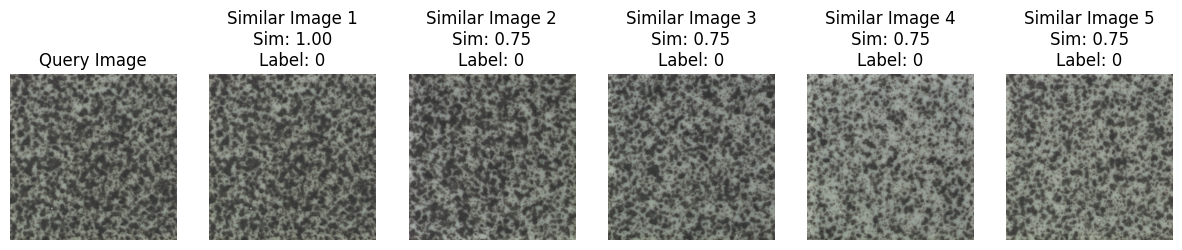

In [36]:
query_image_path = r"/workspaces/eng-ai-agents/assignments/assignment-4/datasets/MVTec/tile/test/good/009.png"
similar_images = find_similar_images(query_image_path, model_name="patchcore")
visualize_similar_images(query_image_path, similar_images)

EfficientAd model

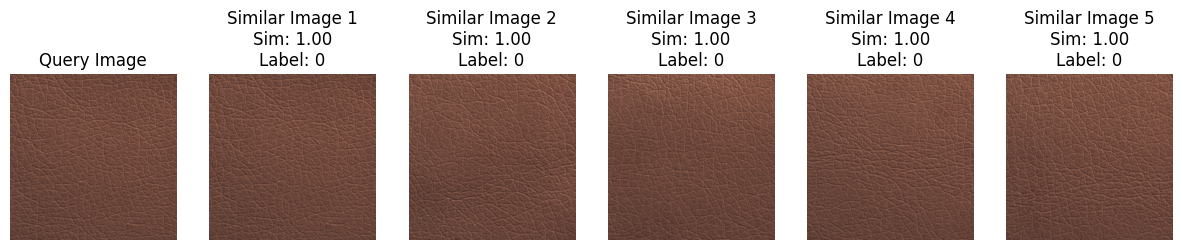

In [47]:
query_image_path = r"/workspaces/eng-ai-agents/assignments/assignment-4/datasets/MVTec/leather/test/good/000.png"
similar_images = find_similar_images(query_image_path, model_name="efficientad")
visualize_similar_images(query_image_path, similar_images)

From the above results, we can see that both models have achieved to find similar images from their respective surface type (tile, leather).  
Also all the similar images have a label 0 (Not an Anomaly), which means that just like the original query, the similar images are normal.

### Query anomalous image

In this experiment, we will select random images from the dataset with some random anomalies and find similar images. Then we will plot them side by side to see if they are also from the same surface class and also have the same label (Label: 1)

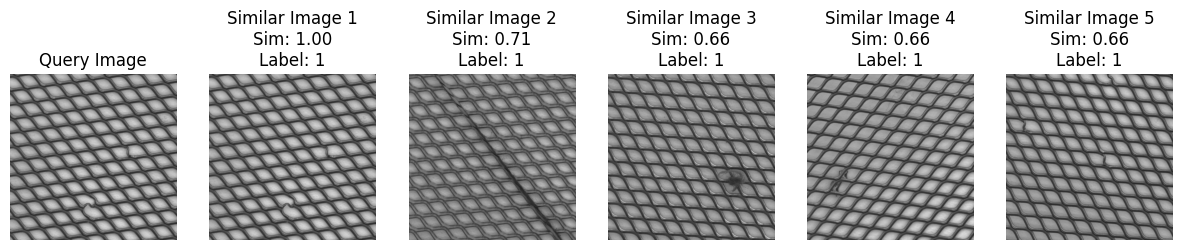

In [37]:
query_image_path = r"/workspaces/eng-ai-agents/assignments/assignment-4/datasets/MVTec/grid/test/bent/001.png"
similar_images = find_similar_images(query_image_path, model_name="patchcore")
visualize_similar_images(query_image_path, similar_images)

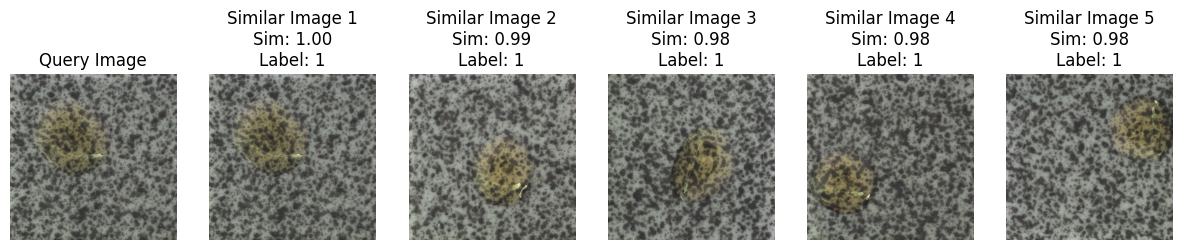

In [46]:
query_image_path = r"/workspaces/eng-ai-agents/assignments/assignment-4/datasets/MVTec/tile/test/oil/007.png"
similar_images = find_similar_images(query_image_path, model_name="efficientad")
visualize_similar_images(query_image_path, similar_images)

From the above results, we can see that both models have achieved to find similar images from their respective surface type (tile, leather).  
Also all the similar images have a label 1 (An Anomaly), which means that just like the original query, the similar images are anomalous.

Conclusion:

We were able to successfully train both models and demonstrate their performance for anomaly detection, and prediction across 3 different surface types. Further, we used the features from the trained models to successfully retrive similar images matching the same conditions as the query.